## Movie Recommendation Project

This Project focuses on the application of recommendation systems, a prominent area within Machine Learning, which customizes content for users to drive business revenue.

Our domain is movie recommendation and our objective is to personalize movie recommendations for each user.

There are two major types of recommendation systems:

### Content-Based Filtering

Recommendations are tailored based on a user's previous preferences and item attributes. The system suggests items similar to those the user has liked before, using features such as movieid, year of release, genre, etc.
    
    
### Collaborative based filtering

  Recommendations rely solely on a user's past preferences and how other users have rated items. This approach disregards item features and user characteristics like age, gender, and location.



_We will be using collaborative filtering algorithms to build our recommender system._

In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.


In [3]:
#Import relevant packages
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "png"

# Ignore printing warnings for general readability
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

# Importing libraries for model building & evaluation
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD
from surprise import accuracy

c:\Users\adeda\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Exploring Movies

Movies tables contains the id, title and genre of movies It has 3883+ records
'movieId' is the unique ID of each movie
'title' reprsents the title of the movies with the year of release in parenthesis
'genere' reprsents the category(ies) the movies belong

In [4]:
#Import the movies file
movies = pd.read_csv('movies.dat', delimiter='::', header=None, encoding='latin1')
movies.columns = ['movieId', 'title', 'genres']
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.shape

(3883, 3)

In [6]:
#Unique values in each dataframe
movies.nunique()

movieId    3883
title      3883
genres      301
dtype: int64

In [7]:
# Check for null values
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
# Check for duplicate values
print(f'Duplicate entries: {movies.duplicated().sum()}')

Duplicate entries: 0


In [9]:
#add a feature 'year' that shows which year the movie is from
movies['release year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies.head()

,movieId,title,genres,release year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [10]:
movies['release year'].value_counts()

release year
1996    345
1995    342
1998    337
1997    315
1999    283
       ... 
1923      3
1919      3
1922      2
1920      2
1921      1
Name: count, Length: 81, dtype: int64

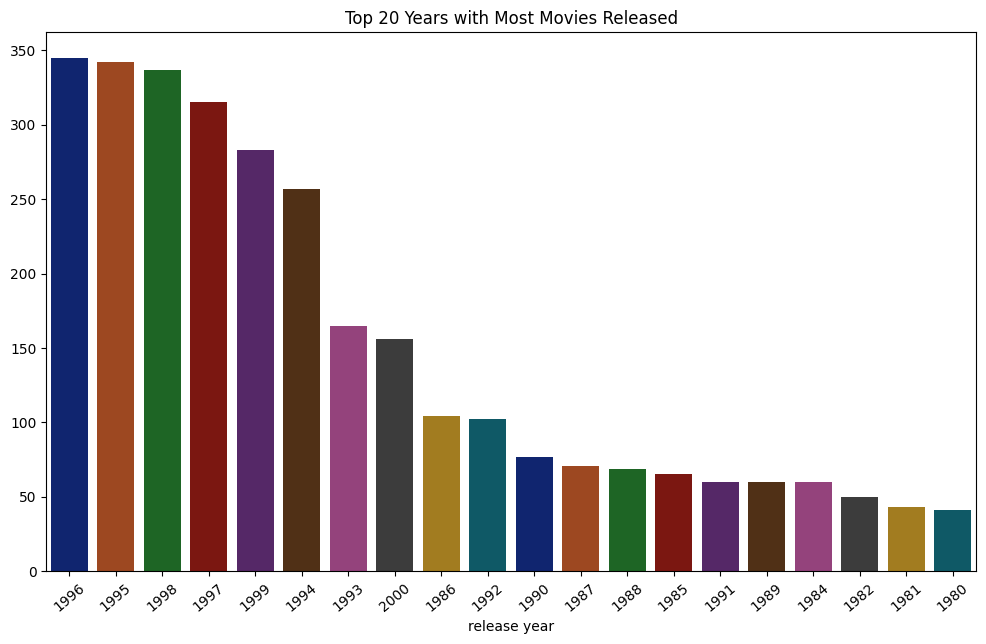

In [11]:
#Top 20 Years with the most movies produced
plt.figure(figsize=(12, 7))
topyear = movies.groupby('release year').size().sort_values(ascending=False).head(20)
sns.barplot(x=topyear.index, y=topyear.values,  palette='dark')
plt.title('Top 20 Years with Most Movies Released')
plt.xticks(rotation=40)
plt.show()

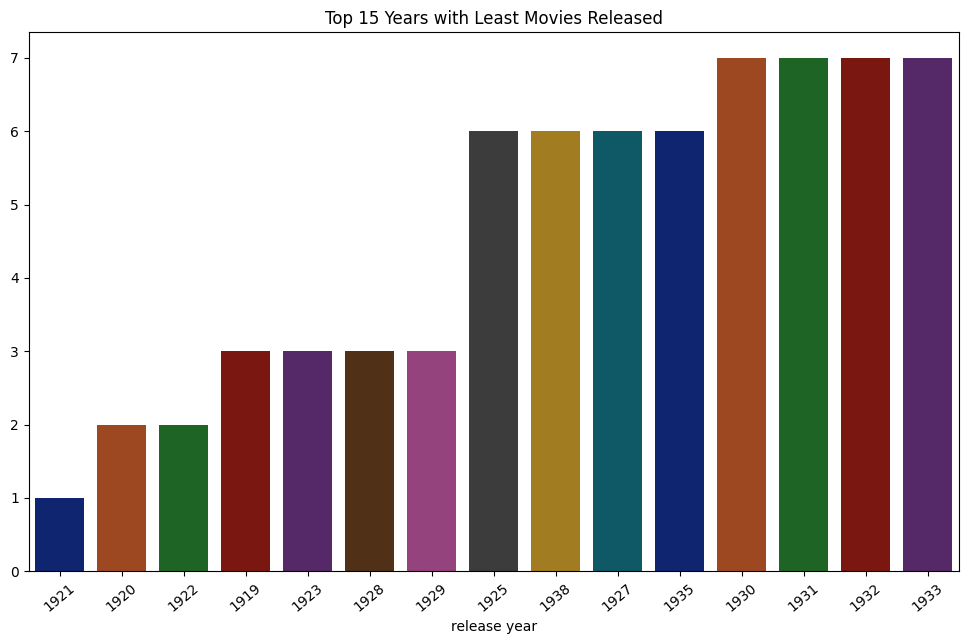

In [12]:
#Top 15 Years with the least movies produced
plt.figure(figsize=(12, 7))
topyear = movies.groupby('release year').size().sort_values(ascending=True).head(15)
sns.barplot(x=topyear.index, y=topyear.values,  palette='dark')
plt.title('Top 15 Years with Least Movies Released')
plt.xticks(rotation=40)
plt.show()

# From the movie dataframe review, the following observations are made:
    - Movies in the dataset were released over 81 years
    - The highest number of movies were released in 1996
    - The least number of movies were released in 1921
    - There are no duplicates
    - There are no null
    - 3883 different movie titles
    - 301 unique genre combinations

# Exploring Ratings Data
rating table contains details of movie ratings by users. Each record represents one rating of one movie by one user,
- It has 1m+ records
    'userid' is the unique ID of each user that rated a movie
    'movieId' reprsents the unique ID of each movie that was rated
    'rating' reprsents the rating of each movie by a user on 5-star scale
    'timestamp' is the time of the rating

In [13]:
ratings = pd.read_csv('ratings.dat', delimiter='::', header=None, encoding='latin1', engine='python')
ratings.columns = ['userId', 'movieId', 'rating', 'timestamp']
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [14]:
# Show unique values in ratings dataframe
ratings.nunique()

userId         6040
movieId        3706
rating            5
timestamp    458455
dtype: int64

In [15]:
ratings.shape

(1000209, 4)

In [16]:
#Unique/distinct values in ratings dataframe
ratings['rating'].value_counts()

rating
4    348971
3    261197
5    226310
2    107557
1     56174
Name: count, dtype: int64

In [17]:
# Show unique values in ratings dataframe
ratings.nunique()

userId         6040
movieId        3706
rating            5
timestamp    458455
dtype: int64

In [18]:
# Check for duplicate values
movies.isnull().sum()

movieId         0
title           0
genres          0
release year    0
dtype: int64

In [19]:
# Check for duplicate values
print(f'Duplicate entries: {ratings.duplicated().sum()}')

Duplicate entries: 0


In [20]:
# Convert Unix timestamp to datetime type
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [21]:
# Use lambda function to extract the year
ratings['rating year'] = ratings['timestamp'].apply(lambda x: x.year)

In [22]:
print(ratings)

         userId  movieId  rating           timestamp  rating year
0             1     1193       5 2000-12-31 22:12:40         2000
1             1      661       3 2000-12-31 22:35:09         2000
2             1      914       3 2000-12-31 22:32:48         2000
3             1     3408       4 2000-12-31 22:04:35         2000
4             1     2355       5 2001-01-06 23:38:11         2001
...         ...      ...     ...                 ...          ...
1000204    6040     1091       1 2000-04-26 02:35:41         2000
1000205    6040     1094       5 2000-04-25 23:21:27         2000
1000206    6040      562       5 2000-04-25 23:19:06         2000
1000207    6040     1096       4 2000-04-26 02:20:48         2000
1000208    6040     1097       4 2000-04-26 02:19:29         2000

[1000209 rows x 5 columns]


## - The rating year attribute extracted from the timestamp is useful for analysing the distribution of rating over the years

In [23]:
ratings['rating year'].value_counts()

rating year
2000    904757
2001     68058
2002     24046
2003      3348
Name: count, dtype: int64

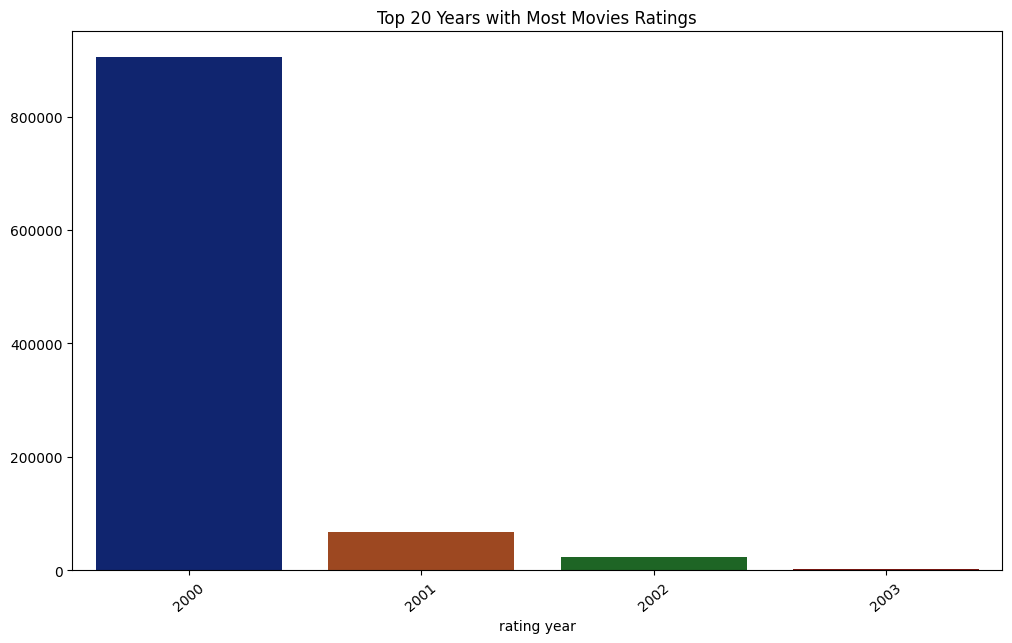

In [25]:
#Years with the most movies rated
plt.figure(figsize=(12, 7))
topyear = ratings.groupby('rating year').size().sort_values(ascending=False).head(10)
sns.barplot(x=topyear.index, y=topyear.values,  palette='dark')
plt.title('Top 20 Years with Most Movies Ratings')
plt.xticks(rotation=40)
plt.show()

In [24]:
rating_types = ratings['rating'].value_counts()
x,y   = rating_types.index, rating_types.values
data  = go.Bar(x=x,y=y, text=y, textposition="outside")
Layout=go.Layout(title="Count of ratings",xaxis={'title':'Rating'},yaxis={'title':'Count'})
go.Figure(data,Layout)

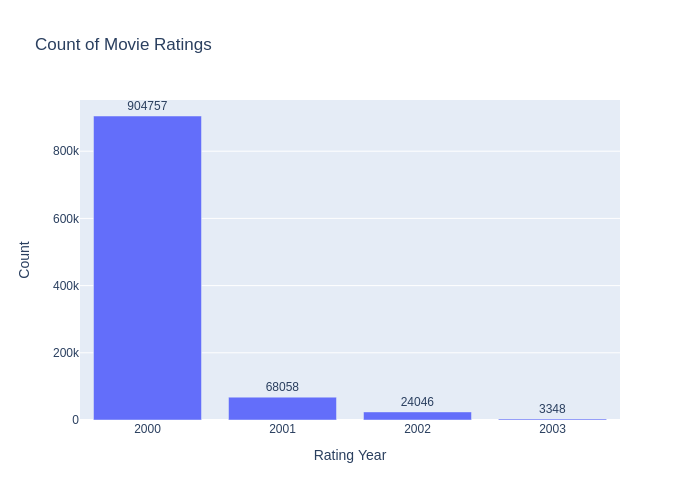

In [ ]:
rating_count = ratings['rating year'].value_counts()
x,y   = rating_count.index, rating_count.values
data  = go.Bar(x=x,y=y, text=y, textposition="outside")
Layout=go.Layout(title="Count of Movie Ratings",xaxis={'title':'Rating Year'},yaxis={'title':'Count'})
go.Figure(data,Layout)

# Observations from Ratings Dataframe:
    - 6040 different users rated movies
    - 3706 different movies were rated
    - There are four years of rating, 2000 to 2003
    - Year 2000 witnessed the highest number of movie rating. Year 2003 has the lowest number
    - There were 348971 4-star ratings being the highest and 56174 being the lowest
    - No null values
    - No duplicates

# The movie and ratings tables contain the relevant columns/fields required for this project use case. To proceed, the movie and ratings dataframes are combined.

## Additional Feature Engineering

In [ ]:
#Merge movies and ratings dataframes to have one single comprehensive data source
df = pd.merge(ratings, movies, on='movieId', how='left')

In [ ]:
df

,userId,movieId,rating,timestamp,rating year,title,genres,release year
0,1,1193,5,2000-12-31 22:12:40,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,1,661,3,2000-12-31 22:35:09,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996
2,1,914,3,2000-12-31 22:32:48,2000,My Fair Lady (1964),Musical|Romance,1964
3,1,3408,4,2000-12-31 22:04:35,2000,Erin Brockovich (2000),Drama,2000
4,1,2355,5,2001-01-06 23:38:11,2001,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41,2000,Weekend at Bernie's (1989),Comedy,1989
1000205,6040,1094,5,2000-04-25 23:21:27,2000,"Crying Game, The (1992)",Drama|Romance|War,1992
1000206,6040,562,5,2000-04-25 23:19:06,2000,Welcome to the Dollhouse (1995),Comedy|Drama,1995
1000207,6040,1096,4,2000-04-26 02:20:48,2000,Sophie's Choice (1982),Drama,1982


In [ ]:
#Drop 'timestamp' as this column is no longer unnecessary
data = df.drop(['timestamp'], axis=1)

In [ ]:
data.head()

,userId,movieId,rating,rating year,title,genres,release year
0,1,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,1,661,3,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996
2,1,914,3,2000,My Fair Lady (1964),Musical|Romance,1964
3,1,3408,4,2000,Erin Brockovich (2000),Drama,2000
4,1,2355,5,2001,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998


In [ ]:
#Check for NA values
data.isna().sum()

userId          0
movieId         0
rating          0
rating year     0
title           0
genres          0
release year    0
dtype: int64

In [ ]:
#Drop any NA values
data.dropna(inplace=True)

In [ ]:
#Confirm no NA values are left
data.isna().sum()

userId          0
movieId         0
rating          0
rating year     0
title           0
genres          0
release year    0
dtype: int64

In [ ]:
#See which movie Ids have the highest number of views
data['movieId'].value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: movieId, Length: 3706, dtype: int64

In [ ]:
#Investigate the number of unique years
data['rating year'].nunique()

4

In [ ]:
#Investigate the number of unique years
data['release year'].nunique()

81

In [ ]:
#Check sparsity of matrix
numratings = len(data['rating'])
numusers = len(data['userId'].unique())
numitems = len(data['movieId'].unique())

sparse = 1 - (numratings / (numusers*numitems))
sparse

0.9553163743776871

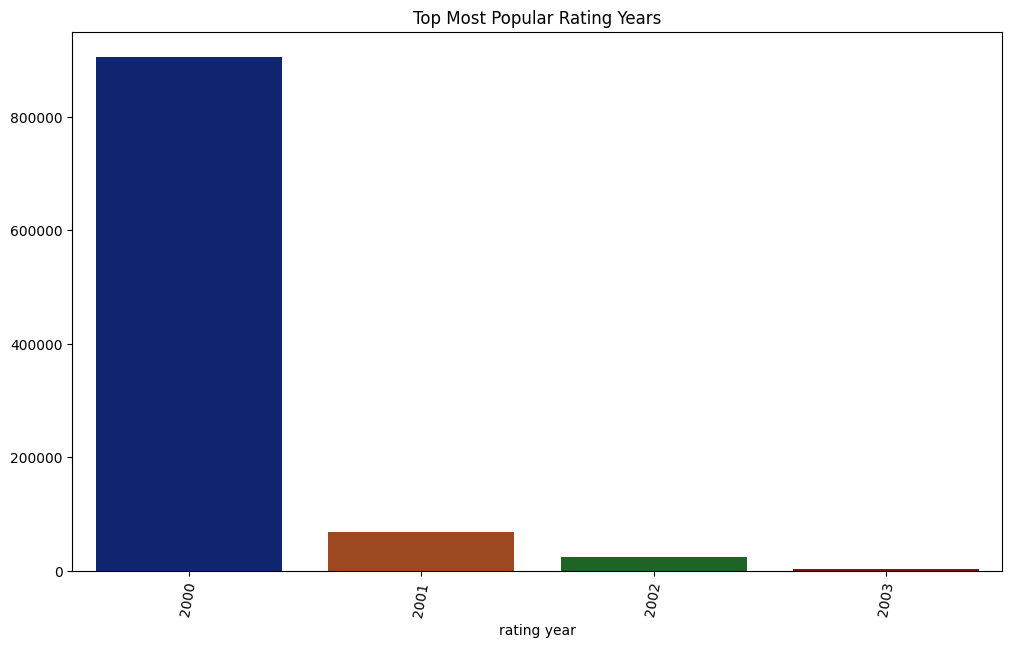

In [ ]:
#Top Years with the most movies rated
plt.figure(figsize=(12, 7))
topyear = data.groupby('rating year').size().sort_values(ascending=False).head(15)
sns.barplot(x=topyear.index, y=topyear.values,  palette='dark')
plt.title('Top Most Popular Rating Years')
plt.xticks(rotation=80)
plt.show()

In [ ]:
#Print the average ratings of movies
data.groupby('title').mean()['rating'].sort_values(ascending=False)

title
Ulysses (Ulisse) (1954)                                       5.0
Lured (1947)                                                  5.0
Follow the Bitch (1998)                                       5.0
Bittersweet Motel (2000)                                      5.0
Song of Freedom (1936)                                        5.0
                                                             ... 
Fantastic Night, The (La Nuit Fantastique) (1949)             1.0
Cheetah (1989)                                                1.0
Torso (Corpi Presentano Tracce di Violenza Carnale) (1973)    1.0
Mutters Courage (1995)                                        1.0
Windows (1980)                                                1.0
Name: rating, Length: 3706, dtype: float64

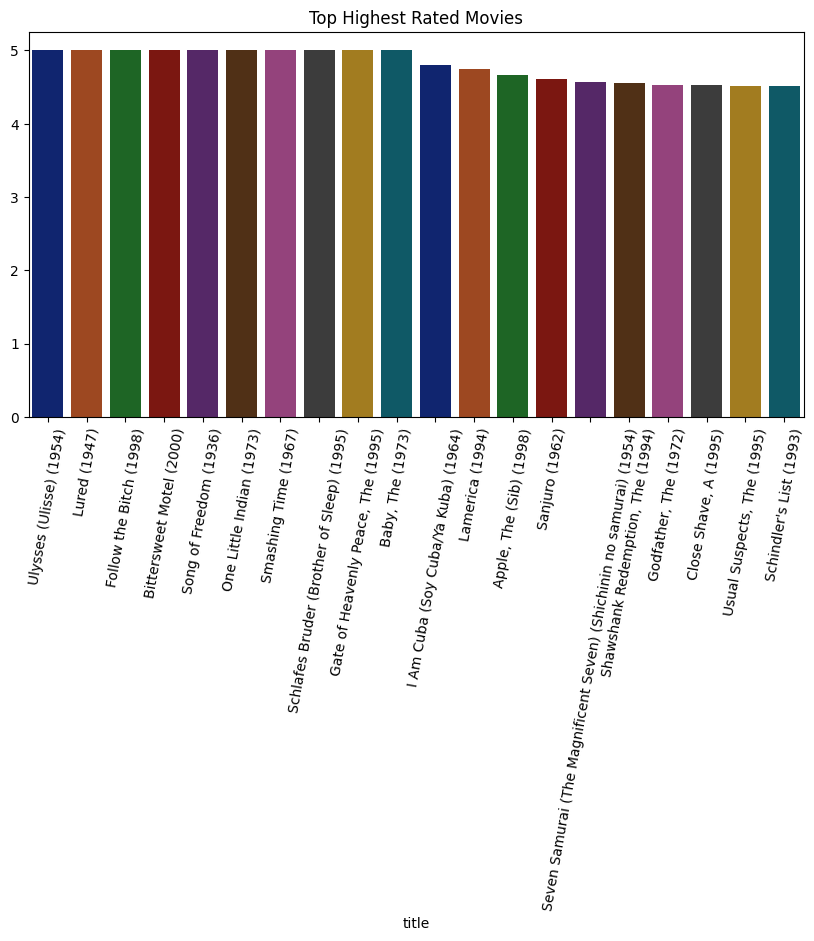

In [ ]:
#Plot the top highest rated movies
plt.figure(figsize=(10,5))
topmovies = data.groupby('title').mean()['rating'].sort_values(ascending=False).head(20)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='dark')
plt.title('Top Highest Rated Movies')
plt.xticks(rotation=80);

By using the mean of ratings to determine the popularity of a movie, it is possible to see a movie with very few but high ratings as being popular than those with higher number of ratings but lower scores

We can also safely say that movies that have been rated by as few as one user increase the probability of training a biased model if they are included in the training dataset.

We'll drop any movies that have not been rated by at least 20 users.

'20' is an arbitrary figure inspired by the minimum number of ratings per user.

In [ ]:
#Filter out users who have rated less than 200 movies
#data = data.groupby('userId').filter(lambda x: len(x)>200)
#Filter out movies who have rated less than 10 movies
data = data.groupby('movieId').filter(lambda x: len(x)>19)


In [ ]:
data.shape

(995492, 7)

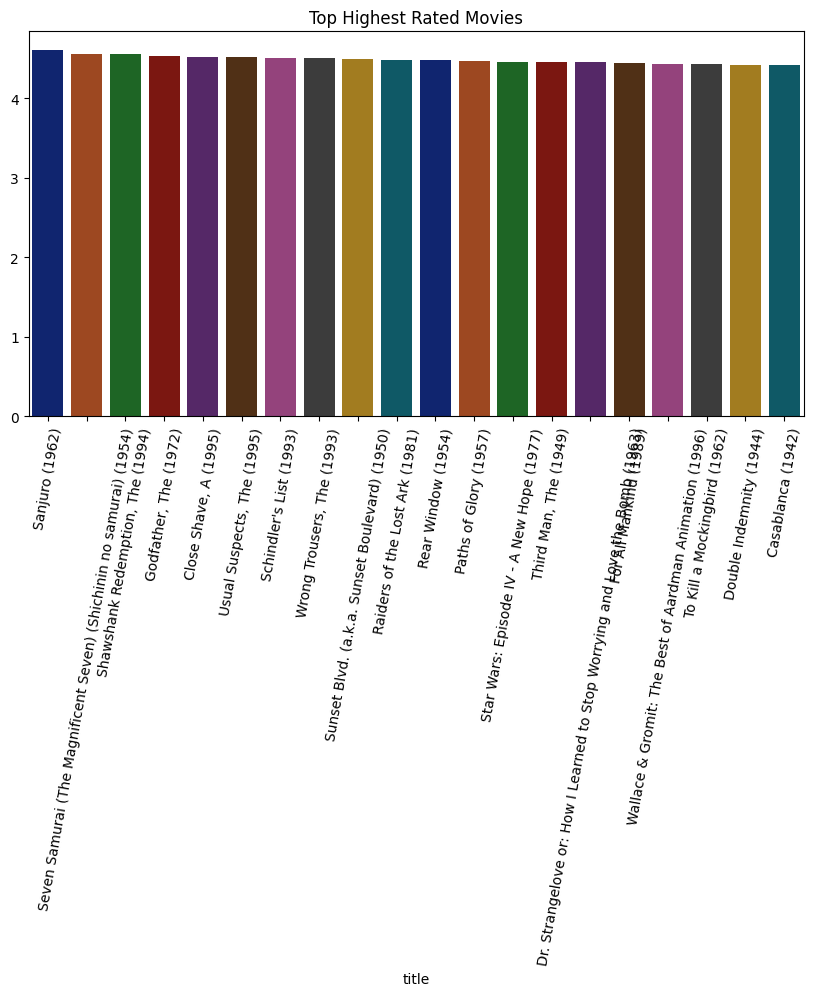

In [ ]:
#Plot the top highest rated movies
plt.figure(figsize=(10,5))
topmovies = data.groupby('title').mean()['rating'].sort_values(ascending=False).head(20)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='dark')
plt.title('Top Highest Rated Movies')
plt.xticks(rotation=80);

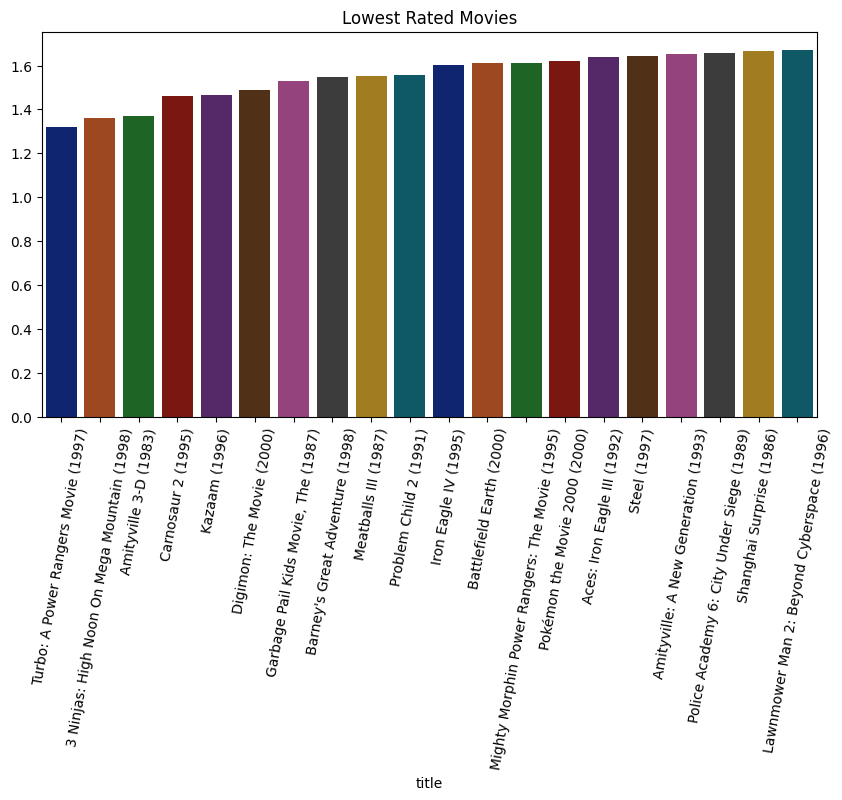

In [ ]:
#Plot the lowest rated movies
plt.figure(figsize=(10,5))
topmovies = data.groupby('title').mean()['rating'].sort_values(ascending=True).head(20)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='dark')
plt.title('Lowest Rated Movies')
plt.xticks(rotation=80);

The most popular and least popular movies using the mean rating changed after the dataset was filtered to have just movies with 20 or more ratings

In [ ]:
# Look at how many times each movie has been watched/rated
data.groupby('title').size().sort_values(ascending=False)

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
                                                         ... 
Rich Man's Wife, The (1996)                                20
Paradine Case, The (1947)                                  20
And the Ship Sails On (E la nave va) (1984)                20
Make Mine Music (1946)                                     20
Henry: Portrait of a Serial Killer, Part 2 (1996)          20
Length: 3043, dtype: int64

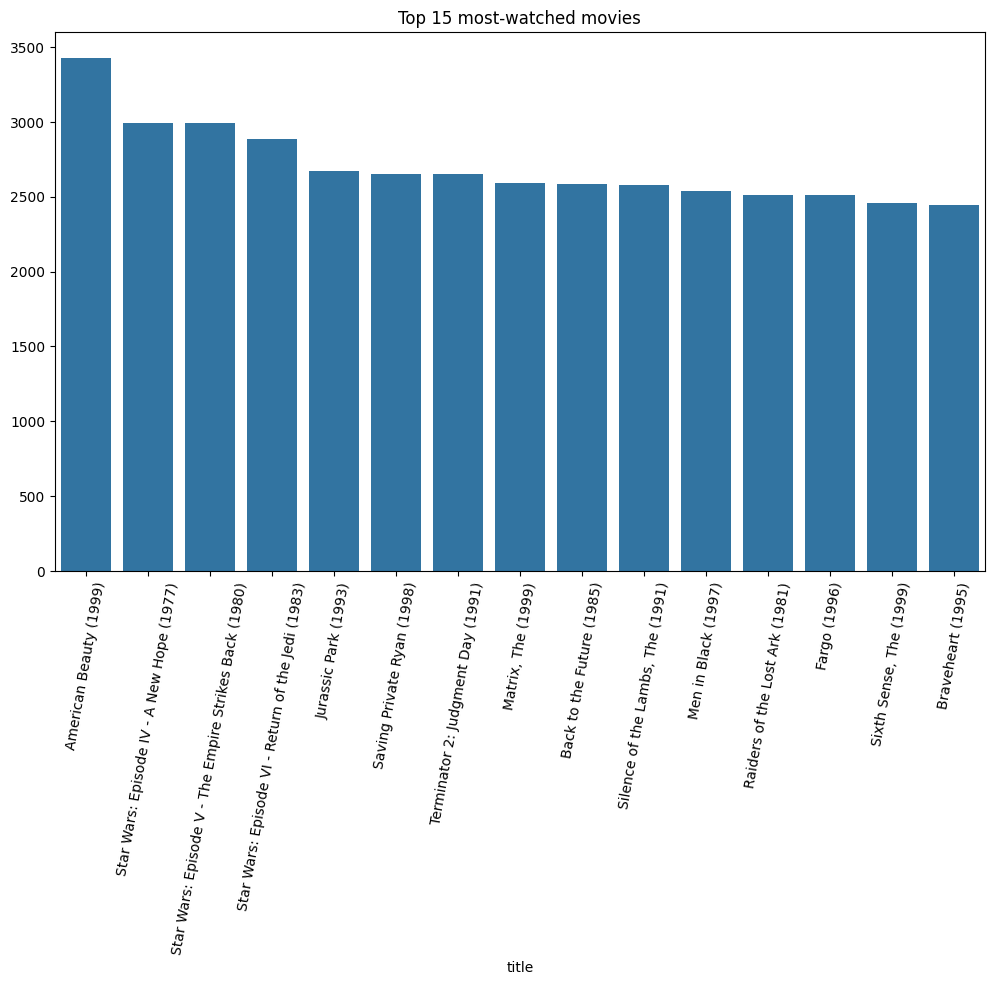

In [ ]:
#Plot the top 10 most watched movies
plt.figure(figsize=(12,7))
topmovies = data.groupby('title').size().sort_values(ascending=False).head(15)
sns.barplot(x=topmovies.index, y=topmovies.values)
plt.title('Top 15 most-watched movies')
plt.xticks(rotation=80);

In [ ]:
#Creat genre labels
genrelabels = set()
for i in data['genres'].str.split('|').values:
    genrelabels = genrelabels.union(set(i))

In [ ]:
#Print genres
genrelabels

{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [ ]:
#function to count how many movies there are of each genre
def genrecounts(df, col, labels):
    count = dict()
    for i in labels: count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): continue
        for i in value:
            if pd.notnull(i): count[i] += 1
    return count

In [ ]:
#Apply the genrecounts formula to our dataset and print the resulting genres and their counts
genre_count = genrecounts(data, 'genres', genrelabels)
genre_count

{"Children's": 72064,
 'Romance': 146985,
 'Fantasy': 36291,
 'Mystery': 40118,
 'Adventure': 133757,
 'War': 68408,
 'Film-Noir': 18183,
 'Action': 257203,
 'Comedy': 355411,
 'Crime': 79281,
 'Musical': 41498,
 'Western': 20629,
 'Horror': 75954,
 'Thriller': 189326,
 'Animation': 43260,
 'Documentary': 7604,
 'Drama': 352431,
 'Sci-Fi': 157140}

In [ ]:
#Apply the genrecounts formula to our dataset and print the resulting genres and their counts
genre_count_mov = genrecounts(movies, 'genres', genrelabels)
genre_count_mov

{"Children's": 251,
 'Romance': 471,
 'Fantasy': 68,
 'Mystery': 106,
 'Adventure': 283,
 'War': 143,
 'Film-Noir': 44,
 'Action': 503,
 'Comedy': 1200,
 'Crime': 211,
 'Musical': 114,
 'Western': 68,
 'Horror': 343,
 'Thriller': 492,
 'Animation': 105,
 'Documentary': 127,
 'Drama': 1603,
 'Sci-Fi': 276}

In [ ]:
#Create a dataframe for the genres and their value counts
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Frequency'])

In [ ]:
#Sort the DataFrame
genres = genres.sort_values(by=['Frequency'], ascending=False)
#Print the resulting DataFrame
genres

,Genre,Frequency
8,Comedy,355411
16,Drama,352431
7,Action,257203
13,Thriller,189326
17,Sci-Fi,157140
1,Romance,146985
4,Adventure,133757
9,Crime,79281
12,Horror,75954
0,Children's,72064


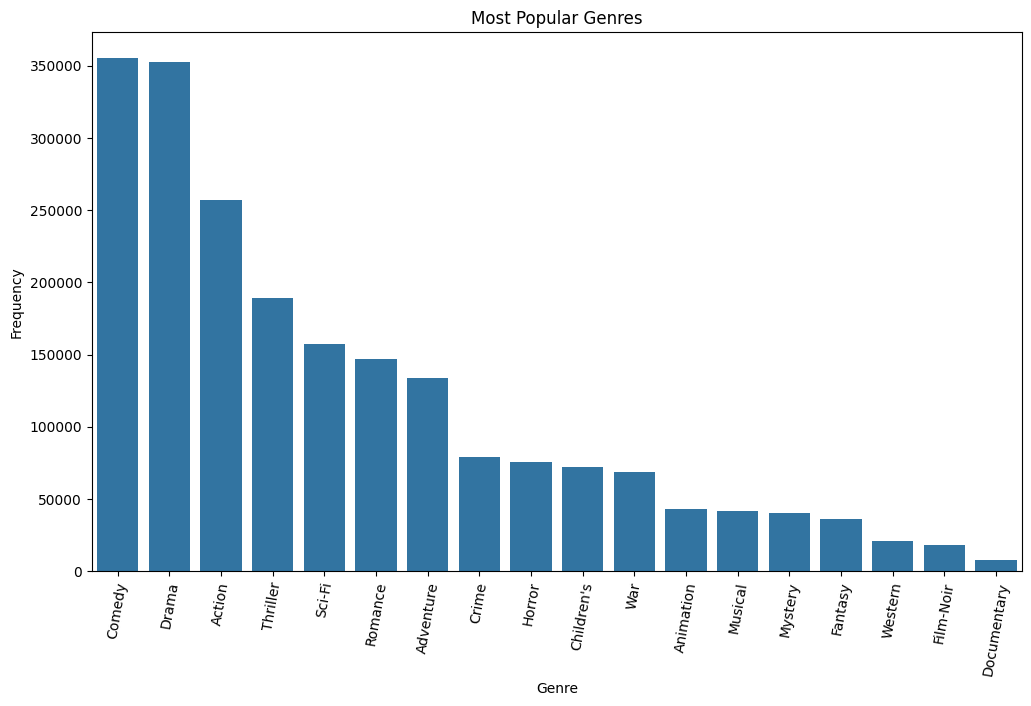

In [ ]:
#Plot the top most watched movie genres
plt.figure(figsize=(12,7))
sns.barplot(x=genres['Genre'], y=genres['Frequency'])
plt.title('Most Popular Genres')
plt.xticks(rotation=80);

We see that Comedy, Drama, and Action are the top 3 genres that are watched by viewers. Again, this information could involve popularity bias when conducting our models; our models may be prone to recommending films that are in Drama, Comedy and Action genres; therefore we must look out for this bias when recommending films to users with our models

In [ ]:
data.head()

In [ ]:
#Create columns for each genre to indicate true or false
for genre in genrelabels:
    data[genre] = data['genres'].apply(lambda x: genre in x)

In [ ]:
#Boolean values for each genre across every movie in the data frame.
pd.set_option('display.max_columns', None)
data.head()

,userId,movieId,rating,rating year,title,genres,release year,Children's,Romance,Fantasy,Mystery,Adventure,War,Film-Noir,Action,Comedy,Crime,Musical,Western,Horror,Thriller,Animation,Documentary,Drama,Sci-Fi
0,1,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,1,661,3,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,1,914,3,2000,My Fair Lady (1964),Musical|Romance,1964,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,1,3408,4,2000,Erin Brockovich (2000),Drama,2000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,1,2355,5,2001,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False


In [ ]:
#Create a logical matrix now that the genres have been parsed.
matrix = data.drop(['userId', 'movieId', 'rating', 'genres', 'rating year', 'release year'], axis=1)
matrix.head()

,title,Children's,Romance,Fantasy,Mystery,Adventure,War,Film-Noir,Action,Comedy,Crime,Musical,Western,Horror,Thriller,Animation,Documentary,Drama,Sci-Fi
0,One Flew Over the Cuckoo's Nest (1975),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,James and the Giant Peach (1996),True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,My Fair Lady (1964),False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,Erin Brockovich (2000),False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,"Bug's Life, A (1998)",True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False


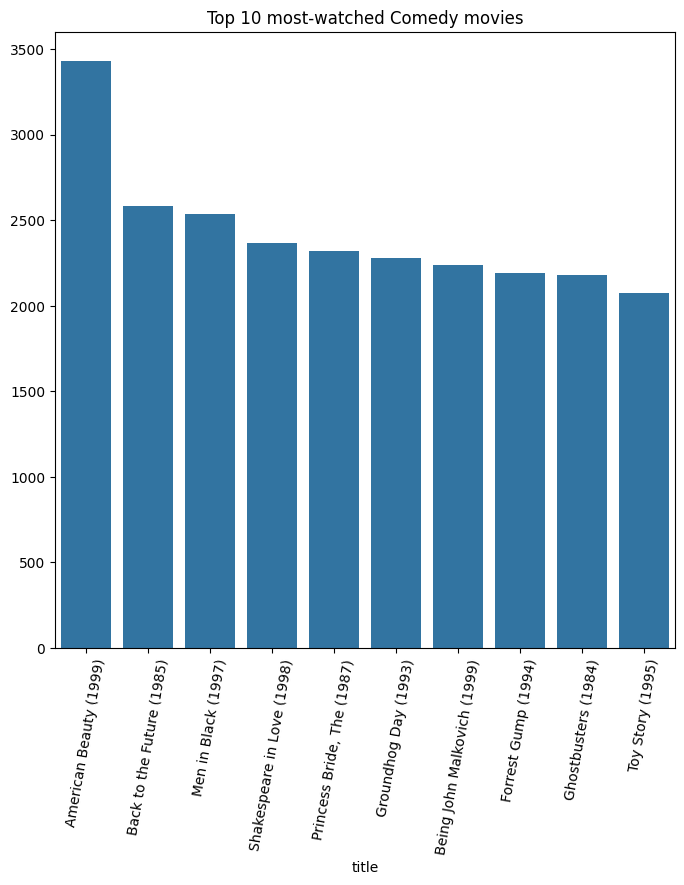

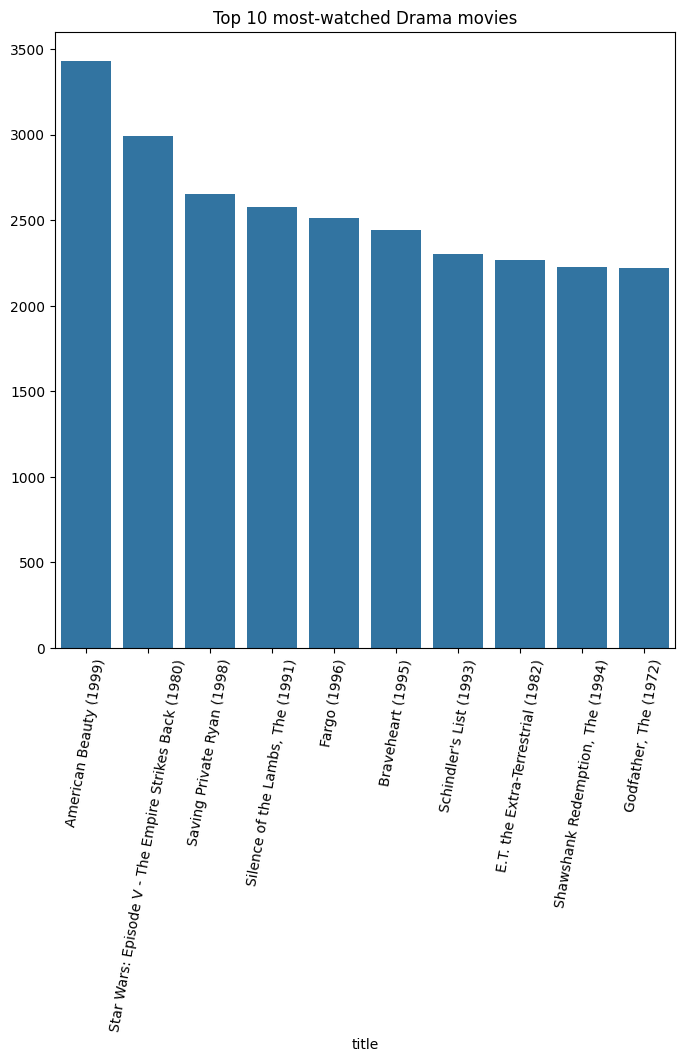

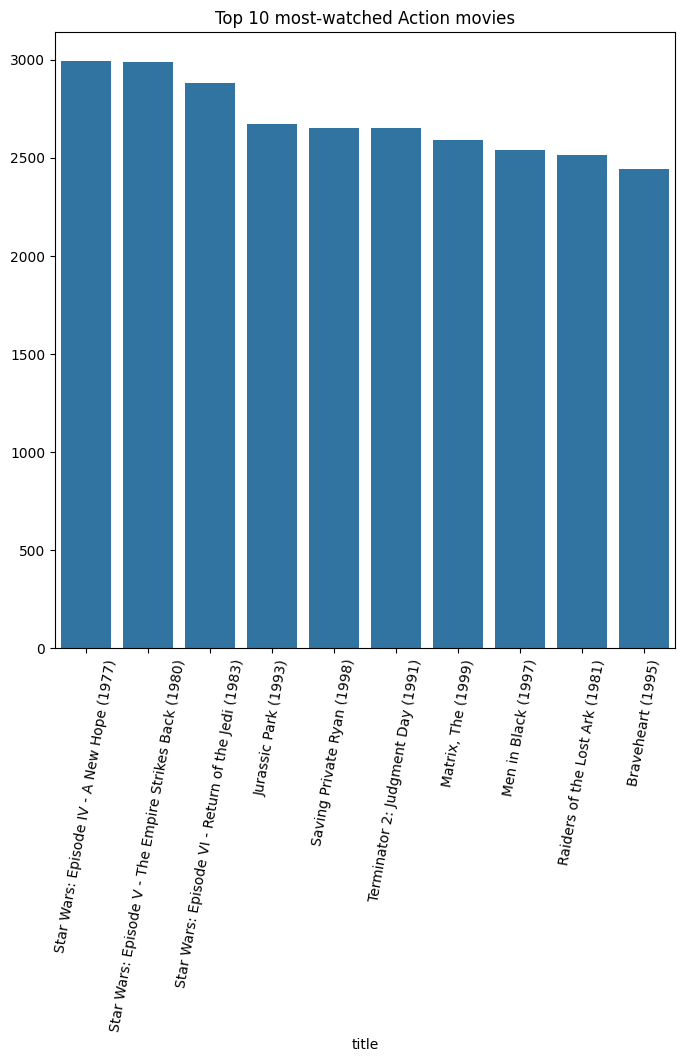

In [ ]:
#plot the top 10 most watched in the most popular genres
m_columns = ['Comedy', 'Drama', 'Action']
for gen in m_columns:
    x = matrix[(matrix[gen]==True)]
    plt.figure(figsize=(8,8))
    topmovies = x.groupby('title').size().sort_values(ascending=False).head(10)
    sns.barplot(x=topmovies.index, y=topmovies.values)
    plt.title('Top 10 most-watched '+gen+' movies')
    plt.xticks(rotation=80);

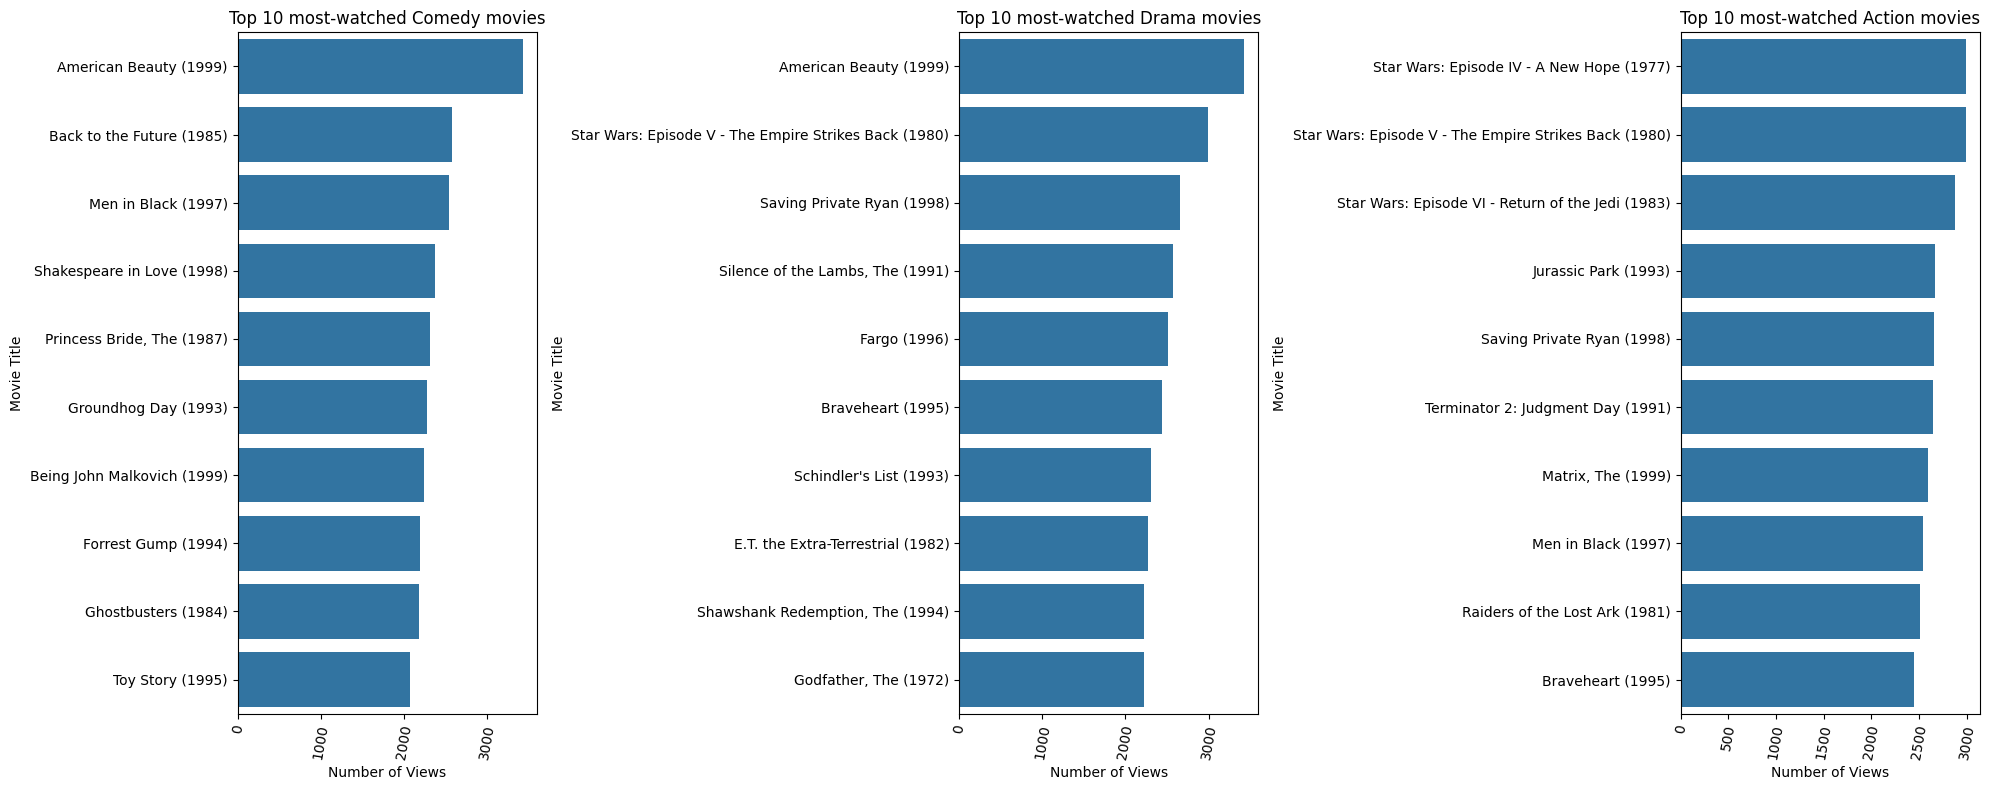

In [ ]:
m_columns = ['Comedy', 'Drama', 'Action']

fig, axs = plt.subplots(1, len(m_columns), figsize=(20, 8))

for i, gen in enumerate(m_columns):
    x = matrix[matrix[gen] == True]
    top_movies = x.groupby('title').size().sort_values(ascending=False).head(10)
    sns.barplot(ax=axs[i], x=top_movies.values, y=top_movies.index)
    axs[i].set_title('Top 10 most-watched ' + gen + ' movies')
    axs[i].set_xlabel('Number of Views')
    axs[i].set_ylabel('Movie Title')
    axs[i].tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.show()

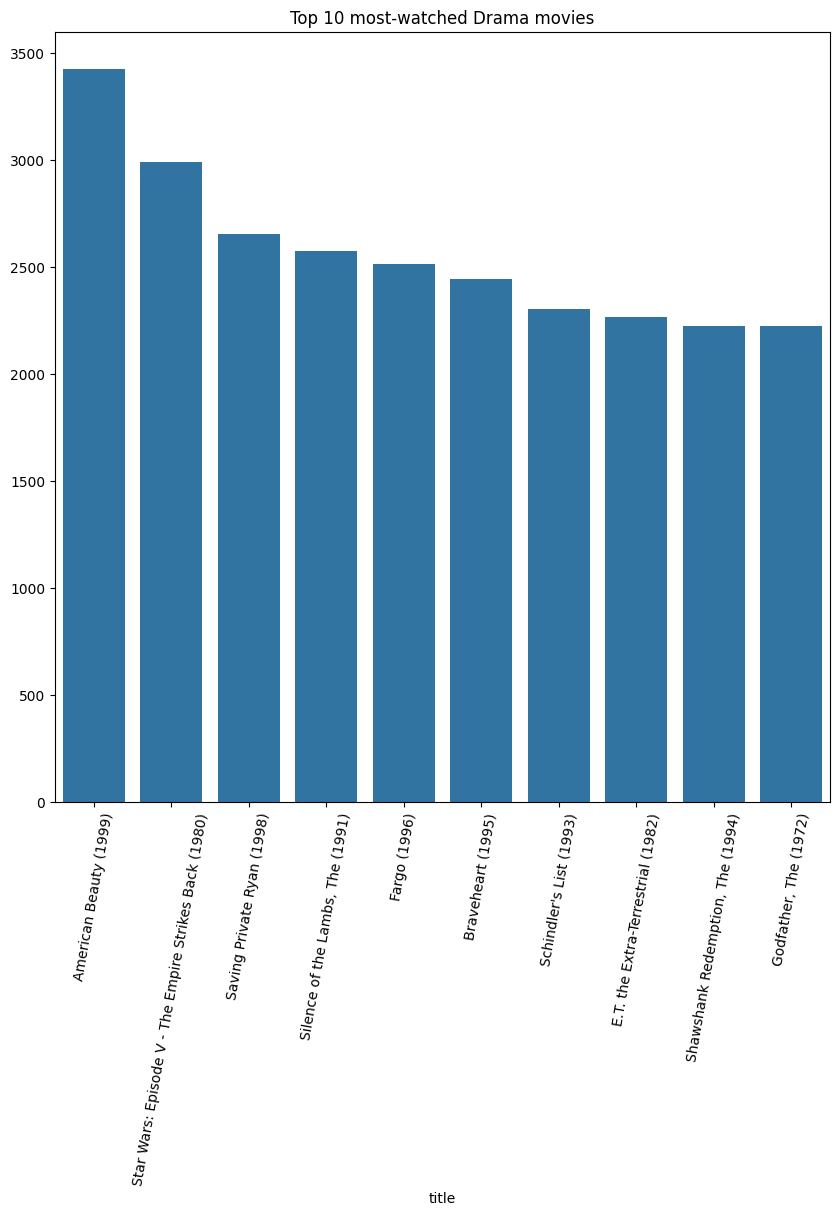

In [ ]:
#Looking at which movies are most popular in the Drama genre
drama = data[(data['Drama']==True)]
plt.figure(figsize=(10,10))
topmovies = drama.groupby('title').size().sort_values(ascending=False).head(10)
sns.barplot(x=topmovies.index, y=topmovies.values)
plt.title('Top 10 most-watched Drama movies')
plt.xticks(rotation=80);

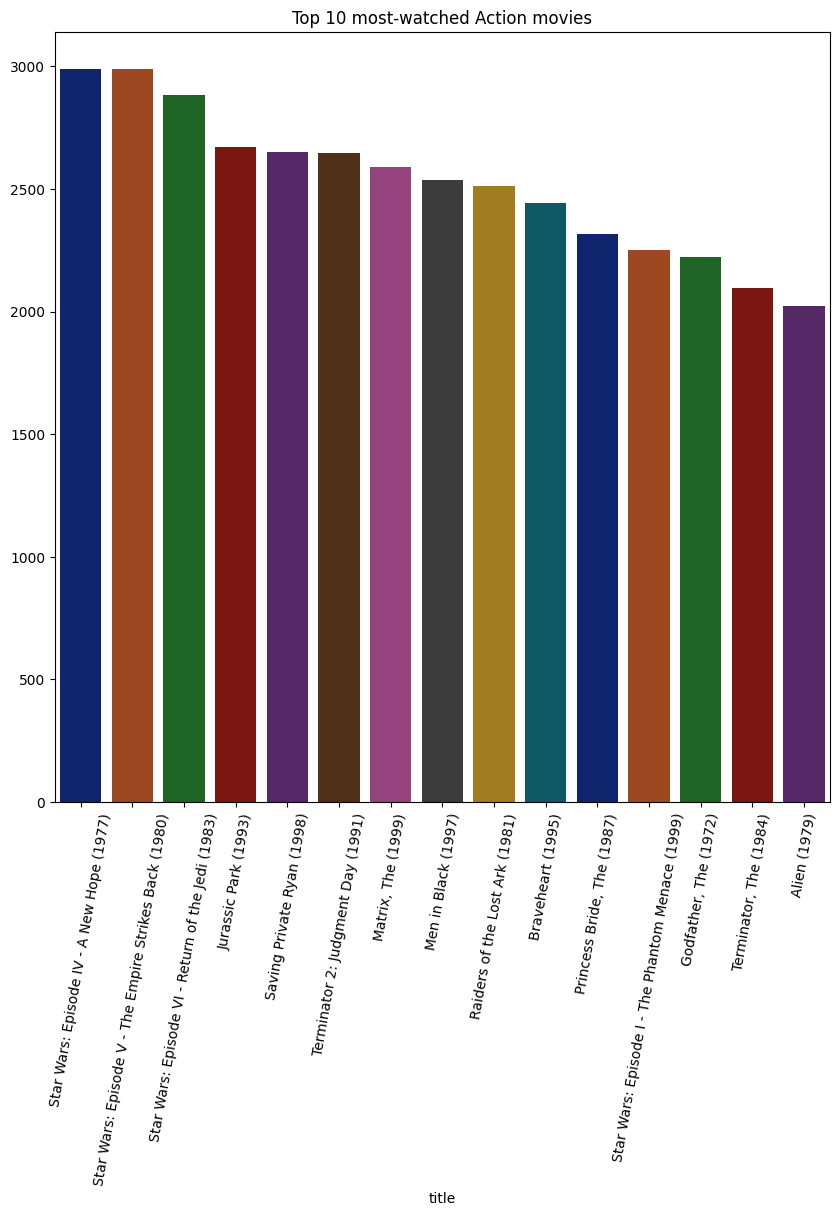

In [ ]:
#Looking at which movies are most popular in the Action genre
action = data[(data['Action']==True)]
plt.figure(figsize=(10,10))
topmovies = action.groupby('title').size().sort_values(ascending=False).head(15)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='dark')
plt.title('Top 10 most-watched Action movies')
plt.xticks(rotation=80);

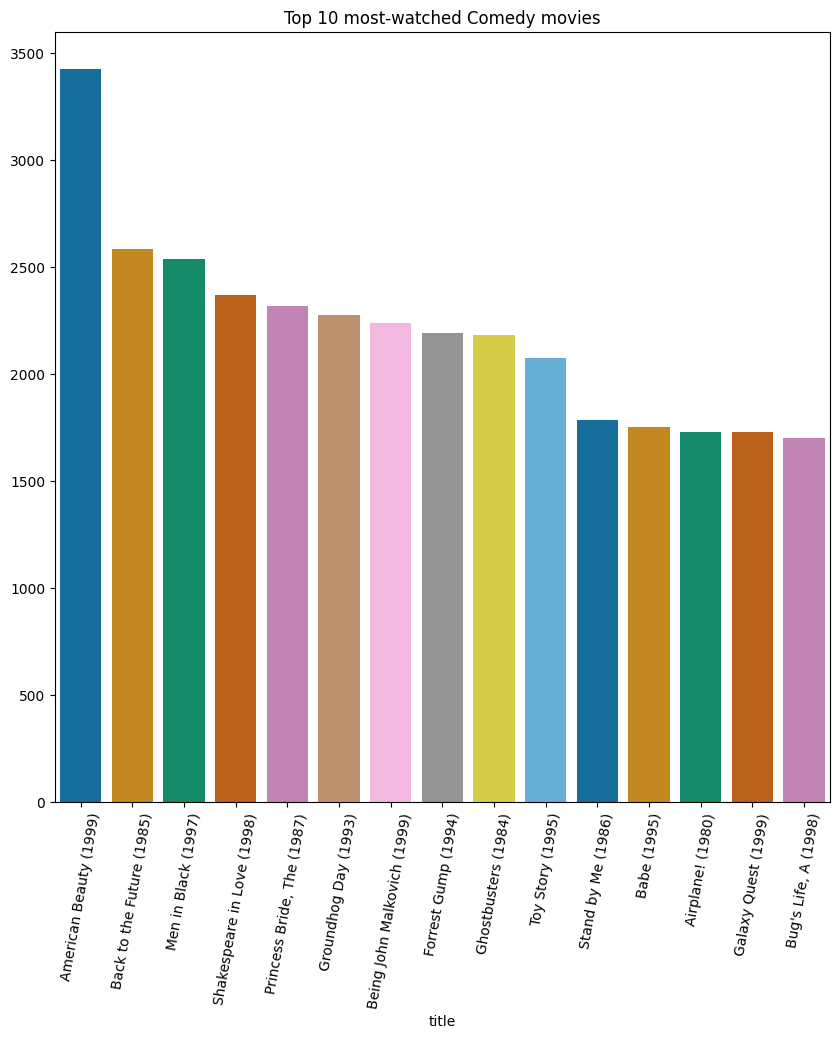

In [ ]:
#Looking at which movies are most popular in the Comedy genre
comedy = data[(data['Comedy']==True)]
plt.figure(figsize=(10,10))
topmovies = comedy.groupby('title').size().sort_values(ascending=False).head(15)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='colorblind')
sns.color_palette("dark")
plt.title('Top 10 most-watched Comedy movies')
plt.xticks(rotation=80);

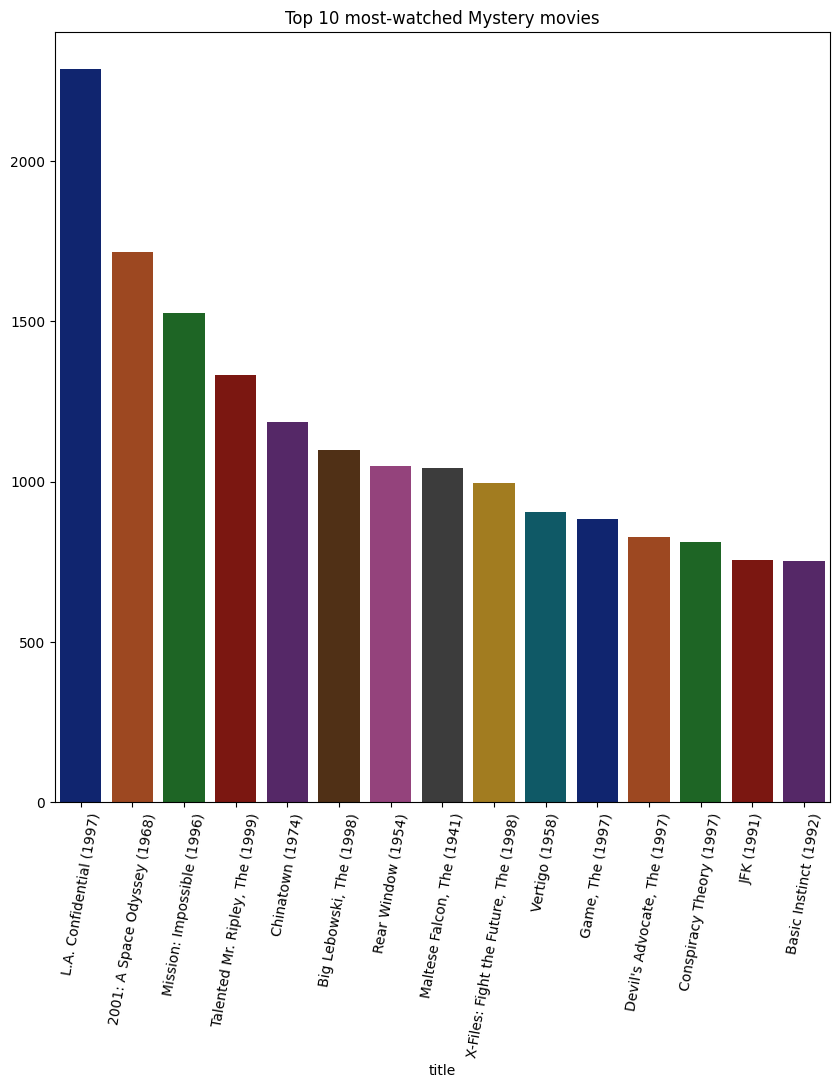

In [ ]:
#Looking at which movies are most popular in the Mystery genre
mystery = data[(data['Mystery']==True)]
plt.figure(figsize=(10,10))
topmovies = mystery.groupby('title').size().sort_values(ascending=False).head(15)
sns.barplot(x=topmovies.index, y=topmovies.values, palette='dark')
plt.title('Top 10 most-watched Mystery movies')
plt.xticks(rotation=80);

In [ ]:
ratings_year = data[data['rating year'] == 2000]
ratings_year

,userId,movieId,rating,rating year,title,genres,release year,Children's,Romance,Fantasy,Mystery,Adventure,War,Film-Noir,Action,Comedy,Crime,Musical,Western,Horror,Thriller,Animation,Documentary,Drama,Sci-Fi
0,1,1193,5,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,1,661,3,2000,James and the Giant Peach (1996),Animation|Children's|Musical,1996,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
2,1,914,3,2000,My Fair Lady (1964),Musical|Romance,1964,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,1,3408,4,2000,Erin Brockovich (2000),Drama,2000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5,1,1197,3,2000,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,1987,False,True,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,2000,Weekend at Bernie's (1989),Comedy,1989,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1000205,6040,1094,5,2000,"Crying Game, The (1992)",Drama|Romance|War,1992,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
1000206,6040,562,5,2000,Welcome to the Dollhouse (1995),Comedy|Drama,1995,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
1000207,6040,1096,4,2000,Sophie's Choice (1982),Drama,1982,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [ ]:
top_movies_2000 = ratings_year.groupby('title').size().sort_values(ascending=False).head(20)
top_movies_2000

Text(0.5, 0, 'Year')

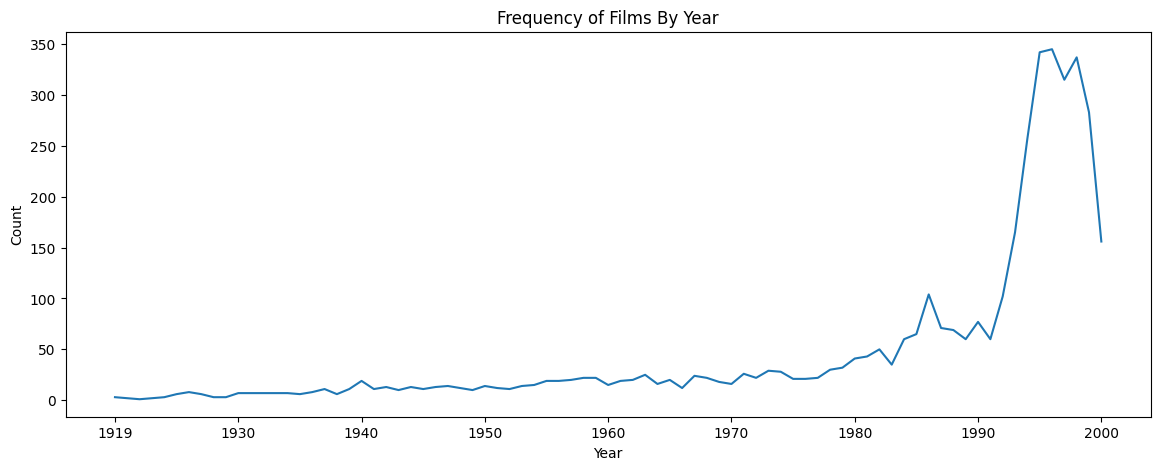

In [ ]:
count_by_year = movies.groupby('release year')['title'].count()
plt.figure(figsize=(14,5))
count_by_year.plot()
plt.title('Frequency of Films By Year')
plt.ylabel('Count')
plt.xlabel('Year')

In [ ]:
rating_movies = ratings['movieId'].value_counts().reset_index() # gettimg the rating count per movie
#keeping only movies with at least 20 ratings
ratings_cut = ratings[ratings['movieId'].isin(rating_movies[rating_movies['movieId']> 19].movieId)]
ratings_cut['userId'].value_counts().reset_index()
ratings_full = ratings_cut.merge(movies, on="movieId") # merging with movies df
ratings_full.head()

,userId,movieId,rating,timestamp,rating year,title,genres,release year
0,1,1193,5,2000-12-31 22:12:40,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
1,2,1193,5,2000-12-31 21:33:33,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
2,12,1193,4,2000-12-30 23:49:39,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
3,15,1193,4,2000-12-30 18:01:19,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975
4,17,1193,5,2000-12-30 06:41:11,2000,One Flew Over the Cuckoo's Nest (1975),Drama,1975


### ML Model Selection

In [ ]:
import random

my_seed = 26
random.seed(my_seed)
# the Reader class is used to parse a file containing ratings.
# it has an important 'rating_scale' parameter with a default...
# value of (1,5) so is unenecessary to change since our ratings
# range from 1 to 5.
reader = Reader()

# used to load a custom dataset stored in pd dataframe.
# its first parameter expects an argument of pd dataframe with 3 columns...
# 'user id', 'item id' and 'rating' in that order...
# for 'item id' we use 'title' to make the prediction easier to interprete...
# and avoid having to merge tables to find out the title of the predicted movie
# it is also safe to do since all movie titles in the dataset are unique.

data = Dataset.load_from_df(ratings_full[['userId','title','rating']], reader)


# For the unusual method of splitting surprise datasets please refer to
# https://surprise.readthedocs.io/en/stable/FAQ.html

raw_ratings = data.raw_ratings


random.shuffle(raw_ratings)                 # shuffle dataset

threshold   = int(len(raw_ratings)*0.8)

train_raw_ratings = raw_ratings[:threshold] # 80% of data is trainset
test_raw_ratings  = raw_ratings[threshold:] # 20% of data is testset

data.raw_ratings = train_raw_ratings        # data is now the trainset
trainset         = data.build_full_trainset()
testset          = data.construct_testset(test_raw_ratings)

Python's surprise library has several built-in algorithms for building rating based recommendation systems.

For this project we'll be considering only collaborative filtering algorithms which aim to predict a user's rating of an item they haven't rated before.

We'll start with five of them:

- KNN (with four variations including KNNBasic,KNNWithMeans,KNNWithZScore and KNNBaseline)
- SVD

We'll evaluate the five algorithms using MAE and RSME and go one step further to apply hyperparameter tuning to SVD and the best of the KNN variations.

We'll then compare the performance and output of the best KNN (with best hyperparameters) with SVD (with the best hyperparameters).

But first let's differentiate all five algorithms:

#### KNN (K Nearest Neighbours)  and its variations

For all variations, the major difference is in the way they compute the similarities between two users or items and how ratings are predicted.
- KNNBasic

It is the simplest form of the KNN algorithm in Surprise and computes similarities between users or items based on their raw ratings. Predictions are made by taking a weighted average of the ratings of the k-nearest neighbors.

- KNNWithMeans

Here, the mean rating of each user (or item) is subtracted from their respective ratings. It computes similarities between users or items based on the mean-centered ratings. Predictions are made by adding back the mean rating to the weighted average of the mean-centered ratings of the k-nearest neighbors.

- KNNWithZScore

Similar to KNNWithMeans, this model also mean-centers the ratings of users or items. Additionally, it scales the mean-centered ratings by the standard deviation of each user (or item). This normalization helps in adjusting for differences in rating scales and variability between users or items.

- KNNBaseline
This model extends the basic KNN algorithm by incorporating baseline estimates. Baseline estimates are used to adjust the raw ratings by considering user and item biases. It computes similarities between users or items based on the baseline-corrected ratings. Predictions are made by taking a weighted average of the baseline-corrected ratings of the k-nearest neighbors.

All four KNN variations come with several hyperparameters; we'll focus on only `k` and `min_k`.

`k` - The (max) number of neighbors to take into account for computing the predicted rating for users or products. The default is '40' and behaves the same for all four KNN variations. Scenarios that may warrant the number of neighbours used for computaion being less than `k` are:
- there might just not exist enough neighbors and
- only neighnours with a positive similarity measure are included.

`min_k` - is the minimum number of neighbors to take into account for aggregation. The default is 1 and it results in different behaviours for each variation (except KNNWithMeans and KNNWithZScore) if there are not enough neighbours:

- For KNNBasic: the prediction is set to the global mean of all ratings
- For KNNWithMeans: the prediction is set to the mean of a user or item's ratings.
- For KNNWithZScore: the prediction is set to the mean of a user or item's ratings.
- For KNNBaseline: the prediction ends up being equivalent to the baseline.

#### SVD (Singular Value Decomposition)
It takes a matrix factorization approach that aims to capture latent factors (potential features) underlying user preferences and item characteristics by decomposing the user-item interaction matrix into lower-dimensional matrices. These latent factors represent underlying patterns or features that influence user-item interactions. The default number of latent factors is 100 and SVD computes a score between each user and each factor and each item and each factor and aims to use this decomposition to predict a user's prediction of an item that they have not predicted before.

In [ ]:
# With the following code, we'll use MAE and RMSE to evaluate KNN's four variations & SVD
# using default model parameters

models=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline(),SVD()]
results = {}

for model in models:
    # cv = 5 sets number of cross validation folds to 5,
    # n_jobs = -1 sets the number of CPUs for running cross validation to all CPUs
    CV_scores = cross_validate(model, data, measures=["MAE","RMSE"], cv=5, n_jobs = -1)
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result

In [ ]:
performance_df = pd.DataFrame.from_dict(results) # converts the results dictionary to pandas dataframe
print("Model Performance: \n")
performance_df.T.sort_values(by='RMSE')

Model Performance: 



,MAE,RMSE,fit_time,test_time
matrix_factorization.SVD,0.708782,0.900625,2.949728,0.380213
knns.KNNBaseline,0.712785,0.903175,7.950352,33.268200
knns.KNNBasic,0.740681,0.937835,7.305481,30.549353
knns.KNNWithMeans,0.764457,0.961210,7.511369,32.817302
knns.KNNWithZScore,0.765947,0.965089,9.212305,32.542464


**Highlights**

- SVD performs best overall on all metrics
- KNNBaseline performs best on all error metrics of all KNN algorithms

### Hyperparameter tuning

As mentioned earlier we'll perform some hyperparameter tuning on SVD and the best performing KNN variation (KNNBaseline).

#### KNNWithBaseline

Here we'll be tuning the `sim_options` and `bsl_options` hyperparameters. They are dictionaries that have some interesting keys and possible values that we will tune. Let's discuss some of them:
- user_based: determines if the model will be a user-based (_True_) or item-based (_False_) collaborative filtering approach
- name: determines the type of similarity to use. It is recommended to use pearson_baseline for best results with this variation of KNN.
- min_support: This refers to minimum number of users (or items) that two items (or users) must have in common before computing a similarity score. If the number of common items/users between them is less than the `min_support`, the similarity score is set to zero.

In [ ]:
# Hyperparameter tuning - KNNWithBaseline

param_grid = { 'sim_options' : {'name': ['msd','cosine', 'pearson_baseline'], \
                                'min_support': [3,5], \
                                'user_based': [False, True]},
              'bsl_options' : {"method": ["als", "sgd"]}
             }

rs_KNNBase = RandomizedSearchCV(KNNBaseline, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1, n_iter=10)

rs_KNNBase.fit(data)

print(f'MAE Best Parameters:  {rs_KNNBase.best_params["mae"]}')
print(f'MAE Best Score:       {rs_KNNBase.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {rs_KNNBase.best_params["rmse"]}')
print(f'RMSE Best Score:      {rs_KNNBase.best_score["rmse"]}\n')

MAE Best Parameters:  {'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': True}, 'bsl_options': {'method': 'sgd'}}
MAE Best Score:       0.6896271841364219

RMSE Best Parameters: {'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': True}, 'bsl_options': {'method': 'sgd'}}
RMSE Best Score:      0.8852127168947019



**Highlights**
- After Hyperparameter Tuning with RandomizedSearchCV, MAE and RMSE agree on the best parameters

- As earlier metioned in the documentation, using a `pearson_baseline` type of similarity will produce the best result,

- We'll build our KNN based model using the returned best hyperparameters.

- There's no need to explicitly give a value for `bsl_options` since the returned `als` is a default value.

In [ ]:
# fitting and predicting with the best knnbaseline hyperparameters

sim_options = {'name':'pearson_baseline','min_support':3,'user_based':False}
final_model = KNNBaseline(sim_options=sim_options)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance:')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Unbiased Testing Performance:
MAE:  0.6901
RMSE: 0.8874
MAE: 0.6901095108417293, RMSE: 0.887385623349807


#### SVD
**description of hyperparameters tuned**
- `n_factors`: This refers to number of latent factors (potential features) for matrix factorization/ dimensionality reduction.
- `n_epochs`: This refers to number of iterations of SGD (stochiastic gradient descent) procedure used by SVD for learning the parameters and minimizing error.
- `lr_all` : learning rate for all parameters. Learning rate refers to the step size of SGD algorithm.
- `reg_all`: The regularization term for all parameters

In [ ]:
# Hyperparameter tuning - SVD

param_grid = {"n_factors": range(10,100,20),
              "n_epochs" : [5, 10, 20],
              "lr_all"   : [0.002, 0.005],
              "reg_all"  : [0.2, 0.5]}

gridsearchSVD = GridSearchCV(SVD, param_grid, measures=['mae', 'rmse'], cv=5, n_jobs=-1)

gridsearchSVD.fit(data)

print(f'MAE Best Parameters:  {gridsearchSVD.best_params["mae"]}')
print(f'MAE Best Score:       {gridsearchSVD.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {gridsearchSVD.best_params["rmse"]}')
print(f'RMSE Best Score:      {gridsearchSVD.best_score["rmse"]}\n')

In [ ]:
# Model fit & prediction - SVD

final_model = SVD(n_factors=90, n_epochs=20, lr_all=0.005, reg_all= 0.2)

# Fitting the model on trainset & predicting on testset, printing test accuracy
pred = final_model.fit(trainset).test(testset)

print(f'\nUnbiased Testing Performance')
print(f'MAE: {accuracy.mae(pred)}, RMSE: {accuracy.rmse(pred)}')


Unbiased Testing Performance
MAE:  0.7311
RMSE: 0.9167
MAE: 0.731113702002273, RMSE: 0.916684004653392


### Building recommendations

In [ ]:
# We'll use the entire dataset for building recommendations

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_full[['userId','title','rating']], reader)
trainset = data.build_full_trainset()

In [ ]:
# KNNBaseLine

def generate_recommendationsKNN(user_id, like_recommend, k):

    ''' returns 'k' number of movie recommendations using
        KNNWithBaseline & item based filtering. The function requires three
        integer parameters:
        (1) user_id - userID for which recommendations need to be generated
        (2) like_recommend - number of top recommendations for the userID to be
        considered for making recommendations
        (3) k - number of recommendations to generate for the userID
    '''

    # Compute item based similarity matrix
    sim_options       = {'name': 'pearson_baseline', 'min_support': 3,\
                                         'user_based': False}
    similarity_matrix = KNNBaseline(sim_options=sim_options).fit(trainset).\
                        compute_similarities()

    user_ID = trainset.to_inner_uid(user_id)    # converts the raw userID to innerID
    userRatings = trainset.ur[user_ID]              # method .ur takes user innerID &
                                                   # returns user ratings


    # userRatings is a list of tuples [(i1,r1),(i2,r2),(i3,r3)..]. Each tuple contains an item
    # and the rating given by the user for that item. Next, the tuples will be sorted within the list
    # in decreasing order of rating. Then top 'like_recommend' items & ratings are extracted

    temp_df = pd.DataFrame(userRatings).sort_values(by=1, ascending=False).\
              head(like_recommend)
    userRatings = temp_df.to_records(index=False)

    # for each (item,rating) in top like_recommend user items, multiply the user rating for
    # the item with the similarity score (later is obtained from item similarity_matrix) for
    # all items. This helps calculate the weighted rating for all items. The weighted ratings
    # are added & divided by sum of weights to estimate rating the user would give an item

    recommendations   = {}

    for user_top_item, user_top_item_rating  in userRatings:

        all_item_indices          =   list(pd.DataFrame(similarity_matrix)[user_top_item].index)
        all_item_weighted_rating  =   list(pd.DataFrame(similarity_matrix)[user_top_item].values*\
                                          user_top_item_rating)

        all_item_weights          =   list(pd.DataFrame(similarity_matrix)[user_top_item].values)


        # All items & final estimated ratings are added to a dictionary called recommendations

        for index in range(len(all_item_indices)):
            if index in recommendations:
                # sum of weighted ratings
                recommendations[index] += all_item_weighted_rating[index]
            else:
                recommendations[index]  = all_item_weighted_rating[index]


    for index in range(len(all_item_indices)):
            if all_item_weights[index]  !=0:
                # final ratings (sum of weighted ratings/sum of weights)
                recommendations[index]   =recommendations[index]/\
                                          (all_item_weights[index]*like_recommend)


    # convert dictionary recommendations to a be a list of tuples [(,),(,),(,)]
    # with each tuple being an item & estimated rating user would give that item
    # sort the tuples within the list to be in decreasing order of estimated ratings

    temp_df = pd.Series(recommendations).reset_index().sort_values(by=0, ascending=False)
    recommendations = list(temp_df.to_records(index=False))

    # return k number of recommedations (only return items the user
    # has not previously rated)

    final_recommendations = []
    count = 0

    for item, score in recommendations:
        flag = True
        for userItem, userRating in trainset.ur[user_ID]:
            if item == userItem:
                flag = False       # If item in recommendations has not been rated by user,
                break              # add to final_recommendations
        if flag == True:
            final_recommendations.append(trainset.to_raw_iid(item))
            count +=1              # trainset has the items stored as inner id,
                                   # convert to raw id & append

        if count == k:  # Only get 'k' number of recommendations
            break

    return(final_recommendations)

Function's code was adapted from Rochita Sundar's [Notebook](https://github.com/rochitasundar/Collaborative-Filtering-Book-Recommendation-System/blob/master/Book%20Recommendation%20Project.ipynb).

**Recommendations for user *4169***

In [ ]:
recomm_4169 = generate_recommendationsKNN(4169, 5, 10)
recomm_4169

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


["Widows' Peak (1994)",
 'In the Army Now (1994)',
 'Son in Law (1993)',
 'Drop Zone (1994)',
 'Beverly Hillbillies, The (1993)',
 'Poltergeist III (1988)',
 'Mighty Morphin Power Rangers: The Movie (1995)',
 'Drop Dead Fred (1991)',
 'Fluke (1995)',
 'Santa Clause, The (1994)']

In [ ]:
movies[movies['title'].isin(recomm_4169)]

,movieId,title,genres,release year
179,181,Mighty Morphin Power Rangers: The Movie (1995),Action|Children's,1995
224,227,Drop Zone (1994),Action,1994
238,241,Fluke (1995),Children's|Drama,1995
314,317,"Santa Clause, The (1994)",Children's|Comedy|Fantasy,1994
415,419,"Beverly Hillbillies, The (1993)",Comedy,1993
448,452,Widows' Peak (1994),Drama,1994
469,473,In the Army Now (1994),Comedy|War,1994
538,542,Son in Law (1993),Comedy,1993
1110,1126,Drop Dead Fred (1991),Comedy|Fantasy,1991
1927,1996,Poltergeist III (1988),Horror|Thriller,1988


majority of movies recommended to user 4169 are comedy. Drama is next in line for most recommended movies.

In [ ]:
# checking the count of genres where userId 4169 gave ratings above 3
rat_4169 = ratings_full[ratings_full['userId'] == 4169]
rat_4169[rat_4169['rating'] > 3].genres.value_counts().head(10)

Drama              80
Drama|Romance      20
Comedy             17
Comedy|Romance     10
Drama|Thriller     10
Comedy|Drama        8
Thriller            7
Crime|Drama         5
Horror              5
Action|Thriller     5
Name: genres, dtype: int64

**Recommendations for user *1680***

In [ ]:
recomm_1680 = generate_recommendationsKNN(1680, 5, 10)
recomm_1680

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


['Apartment, The (1960)',
 'Mumford (1999)',
 'Garden of Finzi-Contini, The (Giardino dei Finzi-Contini, Il) (1970)',
 'Last Man Standing (1996)',
 'Cowboy Way, The (1994)',
 'Mixed Nuts (1994)',
 'Hype! (1996)',
 'Inkwell, The (1994)',
 'Poetic Justice (1993)',
 'Drunks (1997)']

In [ ]:
movies[movies['title'].isin(recomm_1680)]

,movieId,title,genres,release year
272,275,Mixed Nuts (1994),Comedy,1994
434,438,"Cowboy Way, The (1994)",Action|Comedy,1994
472,476,"Inkwell, The (1994)",Comedy|Drama,1994
506,510,Poetic Justice (1993),Drama,1993
897,909,"Apartment, The (1960)",Comedy|Drama,1960
983,996,Last Man Standing (1996),Action|Drama|Western,1996
1103,1119,Drunks (1997),Drama,1997
1290,1310,Hype! (1996),Documentary,1996
1341,1362,"Garden of Finzi-Contini, The (Giardino dei Fin...",Drama,1970
2814,2883,Mumford (1999),Comedy,1999


In [ ]:
# checking the count of genres where userId 1680 gave ratings above 3
rat_1680 = ratings_full[ratings_full['userId'] == 1680]
rat_1680[rat_1680['rating'] > 3].genres.value_counts().head(10)

Drama              49
Comedy             31
Drama|Romance      14
Comedy|Romance     13
Horror             12
Drama|Thriller     11
Thriller            8
Documentary         8
Comedy|Drama        6
Action|Thriller     4
Name: genres, dtype: int64